# Distance to Confidence

DeepFace performs a hard classification by clearly separating same person and different persons based on the pre-tuned threshold.

This notebook builds a logistic regression model to convert calculated distances to probalistic estimate, indicating how likely the classification is correct, thus giving a softer, more informative measure of certainy.

In [30]:
# built-in dependencies
import itertools
import math

# 3rd party dependencies
import pandas as pd
from deepface import DeepFace
from deepface.modules.verification import find_distance, find_threshold
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [ ]:
detector_backend = "mtcnn" # a robust one

model_names = [
    "VGG-Face", "Facenet", "Facenet512", "ArcFace", "GhostFaceNet",
    "Dlib", "SFace", "OpenFace", "DeepFace", "DeepID", "Buffalo_L"
]

distance_metrics = [
    "cosine", "euclidean", "euclidean_l2", "angular",
]

# Configurations

In [4]:
pd.set_option('display.max_rows', None)

In [5]:
model_name = model_names[1]

In [6]:
print(f"Running an experiment for {model_name} & {detector_backend}...")

Running an experiment for Facenet & mtcnn...


In [8]:
# build models in advance
model = DeepFace.build_model(model_name)
detector = DeepFace.build_model(task="face_detector", model_name=detector_backend)

# Prepare Dataset

In [9]:
idendities = {
 "Angelina": ["img1.jpg", "img2.jpg", "img4.jpg"
    , "img5.jpg", "img6.jpg", "img7.jpg", "img10.jpg", "img11.jpg"],
 "Scarlett": ["img8.jpg", "img9.jpg"],
 "Jennifer": ["img3.jpg", "img12.jpg"],
 "Mark": ["img13.jpg", "img14.jpg", "img15.jpg"],
 "Jack": ["img16.jpg", "img17.jpg"],
 "Elon": ["img18.jpg", "img19.jpg"],
 "Jeff": ["img20.jpg", "img21.jpg"],
 "Marissa": ["img22.jpg", "img23.jpg"],
 "Sundar": ["img24.jpg", "img25.jpg"]
}

In [10]:
positives = []
for key, values in idendities.items():
 for i in range(0, len(values)-1):
  for j in range(i+1, len(values)):
   positive = []
   positive.append(values[i])
   positive.append(values[j])
   positives.append(positive)
 
positives = pd.DataFrame(positives, columns = ["file_x", "file_y"])
positives["actual"] = "Same Person"

In [11]:
samples_list = list(idendities.values())
 
negatives = []
for i in range(0, len(idendities) - 1):
 for j in range(i+1, len(idendities)):
  cross_product = itertools.product(samples_list[i], samples_list[j])
  cross_product = list(cross_product)
 
  for cross_sample in cross_product:
   negative = []
   negative.append(cross_sample[0])
   negative.append(cross_sample[1])
   negatives.append(negative)
 
negatives = pd.DataFrame(negatives, columns = ["file_x", "file_y"])
negatives["actual"] = "Different Persons"

In [ ]:
df = pd.concat([positives, negatives]).reset_index(drop = True)
 
df.file_x = "../tests/dataset/"+df.file_x
df.file_y = "../tests/dataset/"+df.file_y

In [13]:
df.head()

,file_x,file_y,actual
0,dataset/img1.jpg,dataset/img2.jpg,Same Person
1,dataset/img1.jpg,dataset/img4.jpg,Same Person
2,dataset/img1.jpg,dataset/img5.jpg,Same Person
3,dataset/img1.jpg,dataset/img6.jpg,Same Person
4,dataset/img1.jpg,dataset/img7.jpg,Same Person


In [14]:
df.shape

(300, 3)

# Generate Embeddings

In [15]:
pivot = {}
def represent(img_name: str):
    if pivot.get(img_name) is None:
        embedding_objs = DeepFace.represent(img_path=img_name, model_name=model_name, detector_backend=detector_backend)

        if len(embedding_objs) > 1:
            raise ValueError(f"{img_name} has more than one face!")
            
        pivot[img_name] = [embedding_obj["embedding"] for embedding_obj in embedding_objs]
    return pivot[img_name]


In [16]:
img1_embeddings = []
img2_embeddings = []
for index, instance in tqdm(df.iterrows(), total=df.shape[0]):
    img1_embeddings = img1_embeddings + represent(instance["file_x"])
    img2_embeddings = img2_embeddings + represent(instance["file_y"])

df["img1_embeddings"] = img1_embeddings
df["img2_embeddings"] = img2_embeddings

100%|██████████| 300/300 [00:57<00:00,  5.24it/s]


In [17]:
df.head()

,file_x,file_y,actual,img1_embeddings,img2_embeddings
0,dataset/img1.jpg,dataset/img2.jpg,Same Person,"[0.64044189453125, 0.6990252733230591, 2.09229...","[0.2710142731666565, 0.6065636873245239, 0.926..."
1,dataset/img1.jpg,dataset/img4.jpg,Same Person,"[0.64044189453125, 0.6990252733230591, 2.09229...","[-0.08416734635829926, 0.17612755298614502, 1...."
2,dataset/img1.jpg,dataset/img5.jpg,Same Person,"[0.64044189453125, 0.6990252733230591, 2.09229...","[-1.072468876838684, 0.48678186535835266, 1.18..."
3,dataset/img1.jpg,dataset/img6.jpg,Same Person,"[0.64044189453125, 0.6990252733230591, 2.09229...","[-0.1698027402162552, 1.0826836824417114, 1.52..."
4,dataset/img1.jpg,dataset/img7.jpg,Same Person,"[0.64044189453125, 0.6990252733230591, 2.09229...","[-0.4807380735874176, 1.4791054725646973, 1.52..."


# Distance Calculation From Embeddings

In [18]:
for distance_metric in distance_metrics:
    distances = []
    for index, instance in tqdm(df.iterrows(), total=df.shape[0]):
        img1_embeddings = instance["img1_embeddings"]
        img2_embeddings = instance["img2_embeddings"]

        distance = find_distance(
            alpha_embedding=img1_embeddings,
            beta_embedding=img2_embeddings,
            distance_metric=distance_metric
        )
        distances.append(distance)
    
    df[distance_metric] = distances

100%|██████████| 300/300 [00:00<00:00, 12523.55it/s]


In [19]:
df.head()

,file_x,file_y,actual,img1_embeddings,img2_embeddings,cosine,euclidean,euclidean_l2,angular
0,dataset/img1.jpg,dataset/img2.jpg,Same Person,"[0.64044189453125, 0.6990252733230591, 2.09229...","[0.2710142731666565, 0.6065636873245239, 0.926...",0.220304,7.776061,0.663783,0.215374
1,dataset/img1.jpg,dataset/img4.jpg,Same Person,"[0.64044189453125, 0.6990252733230591, 2.09229...","[-0.08416734635829926, 0.17612755298614502, 1....",0.249256,8.289897,0.706053,0.229695
2,dataset/img1.jpg,dataset/img5.jpg,Same Person,"[0.64044189453125, 0.6990252733230591, 2.09229...","[-1.072468876838684, 0.48678186535835266, 1.18...",0.291291,8.865397,0.763271,0.249278
3,dataset/img1.jpg,dataset/img6.jpg,Same Person,"[0.64044189453125, 0.6990252733230591, 2.09229...","[-0.1698027402162552, 1.0826836824417114, 1.52...",0.219916,7.852590,0.663198,0.215176
4,dataset/img1.jpg,dataset/img7.jpg,Same Person,"[0.64044189453125, 0.6990252733230591, 2.09229...","[-0.4807380735874176, 1.4791054725646973, 1.52...",0.184313,7.179951,0.607146,0.196359


In [20]:
df_backup = df.copy()

# Distance To Classification

In [21]:
df = df_backup.copy()

In [22]:
for distance_metric in distance_metrics:
    threshold = find_threshold(model_name=model_name, distance_metric=distance_metric)
    df[f"{distance_metric}_threshold"] = threshold
    df[f"{distance_metric}_decision"] = 0
    idx = df[df[distance_metric] <= threshold].index
    df.loc[idx, f"{distance_metric}_decision"] = 1

In [23]:
df.head()

,file_x,file_y,actual,img1_embeddings,img2_embeddings,cosine,euclidean,euclidean_l2,angular,cosine_threshold,cosine_decision,euclidean_threshold,euclidean_decision,euclidean_l2_threshold,euclidean_l2_decision,angular_threshold,angular_decision
0,dataset/img1.jpg,dataset/img2.jpg,Same Person,"[0.64044189453125, 0.6990252733230591, 2.09229...","[0.2710142731666565, 0.6065636873245239, 0.926...",0.220304,7.776061,0.663783,0.215374,0.4,1,10,1,0.8,1,0.33,1
1,dataset/img1.jpg,dataset/img4.jpg,Same Person,"[0.64044189453125, 0.6990252733230591, 2.09229...","[-0.08416734635829926, 0.17612755298614502, 1....",0.249256,8.289897,0.706053,0.229695,0.4,1,10,1,0.8,1,0.33,1
2,dataset/img1.jpg,dataset/img5.jpg,Same Person,"[0.64044189453125, 0.6990252733230591, 2.09229...","[-1.072468876838684, 0.48678186535835266, 1.18...",0.291291,8.865397,0.763271,0.249278,0.4,1,10,1,0.8,1,0.33,1
3,dataset/img1.jpg,dataset/img6.jpg,Same Person,"[0.64044189453125, 0.6990252733230591, 2.09229...","[-0.1698027402162552, 1.0826836824417114, 1.52...",0.219916,7.852590,0.663198,0.215176,0.4,1,10,1,0.8,1,0.33,1
4,dataset/img1.jpg,dataset/img7.jpg,Same Person,"[0.64044189453125, 0.6990252733230591, 2.09229...","[-0.4807380735874176, 1.4791054725646973, 1.52...",0.184313,7.179951,0.607146,0.196359,0.4,1,10,1,0.8,1,0.33,1


# Confidence Score Calculation

In [24]:
confidence_metrics = {}

for distance_metric in distance_metrics:
    max_value = df[distance_metric].max()

    X = df[distance_metric].values.reshape(-1, 1)

    # normalize the distance values before feeding them to the model
    if max_value > 1:
        X = X / max_value

    y = df[f"{distance_metric}_decision"].values

    model = LogisticRegression().fit(X, y)

    w = model.coef_[0][0]
    b = model.intercept_[0]

    confidence_metrics[distance_metric] = {
        "w": w,
        "b": b,
        "normalizer": max_value,
    }

    confidences =[]
    for index, instance in df.iterrows():
        distance = instance[distance_metric]

        if max_value > 1:
            distance = distance / max_value

        z = w * distance + b
        confidence = 100 / (1 + math.exp(-z))

        confidences.append(confidence)
    
    df[distance_metric + "_confidence"] = confidences

    confidence_metrics[distance_metric]["denorm_max_true"] = df[df[f"{distance_metric}_decision"] == 1][distance_metric + "_confidence"].max()
    confidence_metrics[distance_metric]["denorm_min_true"] = df[df[f"{distance_metric}_decision"] == 1][distance_metric + "_confidence"].min()

    confidence_metrics[distance_metric]["denorm_max_false"] = df[df[f"{distance_metric}_decision"] == 0][distance_metric + "_confidence"].max()
    confidence_metrics[distance_metric]["denorm_min_false"] = df[df[f"{distance_metric}_decision"] == 0][distance_metric + "_confidence"].min()

In [25]:
confidence_metrics

{'cosine': {'w': -6.502269165856082,
  'b': 1.679048923097668,
  'normalizer': 1.206694,
  'denorm_max_true': 77.17253153662926,
  'denorm_min_true': 41.790002608273234,
  'denorm_max_false': 20.618350202170916,
  'denorm_min_false': 0.7976712344840693},
 'euclidean': {'w': -6.716177467853723,
  'b': 2.790978346203265,
  'normalizer': 18.735288,
  'denorm_max_true': 74.76412617567517,
  'denorm_min_true': 40.4423755909089,
  'denorm_max_false': 25.840858374979504,
  'denorm_min_false': 1.9356150486888306},
 'euclidean_l2': {'w': -6.708710331202137,
  'b': 2.9094193067398195,
  'normalizer': 1.553508,
  'denorm_max_true': 75.45756719896039,
  'denorm_min_true': 40.4509428022908,
  'denorm_max_false': 30.555931000001184,
  'denorm_min_false': 2.189644991619842},
 'angular': {'w': -6.371147050396505,
  'b': 0.6766460615182355,
  'normalizer': 0.56627,
  'denorm_max_true': 45.802357900723386,
  'denorm_min_true': 24.327312950719133,
  'denorm_max_false': 16.95267765757785,
  'denorm_min_fa

In [26]:
# denormalize confidence scores
for distance_metric in distance_metrics:
    for index, instance in df.iterrows():
        current_distance = instance[distance_metric]
        threshold = find_threshold(model_name=model_name, distance_metric=distance_metric)

        prediction = "same person" if current_distance <= threshold else "different persons"

        # denormalize same person predictions
        if prediction == "same person":
            min_orginal = confidence_metrics[distance_metric]["denorm_min_true"]
            max_orginal = confidence_metrics[distance_metric]["denorm_max_true"]
            min_target = max(51, min_orginal)
            max_target = 100
        else:
            min_orginal = confidence_metrics[distance_metric]["denorm_min_false"]
            max_orginal = confidence_metrics[distance_metric]["denorm_max_false"]
            min_target = 0
            max_target = min(49, max_orginal)

        confidence = instance[f"{distance_metric}_confidence"]

        confidence_new = (
            (confidence - min_orginal) / (max_orginal - min_orginal)
        ) * (max_target - min_target) + min_target
        
        confidence_new = float(confidence_new)

        # print(f"{prediction}: {confidence}  -> {confidence_new}")

        df.loc[index, f"{distance_metric}_confidence"] = confidence_new

# Results

In [27]:
df[df["actual"] == "Same Person"][[
    "file_x",
    "file_y",
    "actual",
    "cosine",
    "euclidean",
    "euclidean_l2",
    "angular",
    "cosine_confidence",
    "euclidean_confidence",
    "euclidean_l2_confidence",
    "angular_confidence",
]].head(10)

,file_x,file_y,actual,cosine,euclidean,euclidean_l2,angular,cosine_confidence,euclidean_confidence,euclidean_l2_confidence,angular_confidence
0,dataset/img1.jpg,dataset/img2.jpg,Same Person,0.220304,7.776061,0.663783,0.215374,79.066154,64.767739,65.867875,71.428257
1,dataset/img1.jpg,dataset/img4.jpg,Same Person,0.249256,8.289897,0.706053,0.229695,73.892125,58.210897,59.488339,66.878140
2,dataset/img1.jpg,dataset/img5.jpg,Same Person,0.291291,8.865397,0.763271,0.249278,66.154520,51.000000,51.000000,60.905288
3,dataset/img1.jpg,dataset/img6.jpg,Same Person,0.219916,7.852590,0.663198,0.215176,79.134312,63.788618,65.956234,71.492183
4,dataset/img1.jpg,dataset/img7.jpg,Same Person,0.184313,7.179951,0.607146,0.196359,85.226842,72.364455,74.358148,77.685211
5,dataset/img1.jpg,dataset/img10.jpg,Same Person,0.243940,8.278702,0.698483,0.227122,74.854050,58.352994,60.627930,67.684707
6,dataset/img1.jpg,dataset/img11.jpg,Same Person,0.236210,8.214206,0.687329,0.223337,76.243849,59.172585,62.310511,68.880036
7,dataset/img2.jpg,dataset/img4.jpg,Same Person,0.180357,6.822683,0.600594,0.194172,85.882118,76.844969,75.326061,78.419335
8,dataset/img2.jpg,dataset/img5.jpg,Same Person,0.175950,6.651977,0.593211,0.191709,86.606529,78.953612,76.411591,79.249453
9,dataset/img2.jpg,dataset/img6.jpg,Same Person,0.085547,4.755967,0.413635,0.132621,100.000000,100.000000,100.000000,100.000000


In [28]:
df[df["actual"] == "Different Persons"][[
    "file_x",
    "file_y",
    "actual",
    "cosine",
    "euclidean",
    "euclidean_l2",
    "angular",
    "cosine_confidence",
    "euclidean_confidence",
    "euclidean_l2_confidence",
    "angular_confidence",
]].head(10)

,file_x,file_y,actual,cosine,euclidean,euclidean_l2,angular,cosine_confidence,euclidean_confidence,euclidean_l2_confidence,angular_confidence
38,dataset/img1.jpg,dataset/img8.jpg,Different Persons,0.912684,15.971380,1.351062,0.472171,3.094661,3.364286,3.127406,5.404447
39,dataset/img1.jpg,dataset/img9.jpg,Different Persons,0.971642,16.535808,1.394017,0.490972,2.056160,2.406347,2.238199,4.092357
40,dataset/img2.jpg,dataset/img8.jpg,Different Persons,0.718171,13.744342,1.198475,0.409059,9.632836,9.327166,7.763610,10.860674
41,dataset/img2.jpg,dataset/img9.jpg,Different Persons,0.784581,14.418712,1.252662,0.430888,6.713687,7.083039,5.811885,8.776472
42,dataset/img4.jpg,dataset/img8.jpg,Different Persons,0.753150,14.123269,1.227314,0.420605,7.987852,8.012303,6.677761,9.730812
43,dataset/img4.jpg,dataset/img9.jpg,Different Persons,0.829773,14.878502,1.288234,0.445550,5.177442,5.790447,4.724925,7.497093
44,dataset/img5.jpg,dataset/img8.jpg,Different Persons,0.721133,13.643271,1.200943,0.410041,9.483595,9.702528,7.666288,10.762127
45,dataset/img5.jpg,dataset/img9.jpg,Different Persons,0.729796,13.777185,1.208136,0.412909,9.057935,9.207479,7.387416,10.476942
46,dataset/img6.jpg,dataset/img8.jpg,Different Persons,0.717417,13.921246,1.197846,0.408809,9.671131,8.695498,7.788549,10.885836
47,dataset/img6.jpg,dataset/img9.jpg,Different Persons,0.741129,14.200127,1.217481,0.416650,8.524856,7.762737,7.035554,10.110791


We should see that same person classifications should be distributed between 51-100

and different persons classification should be distributed between 0-49

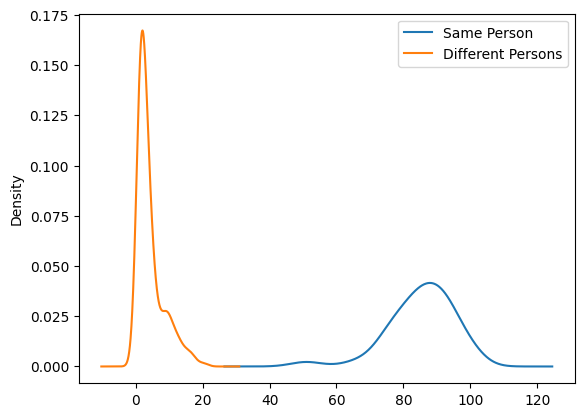

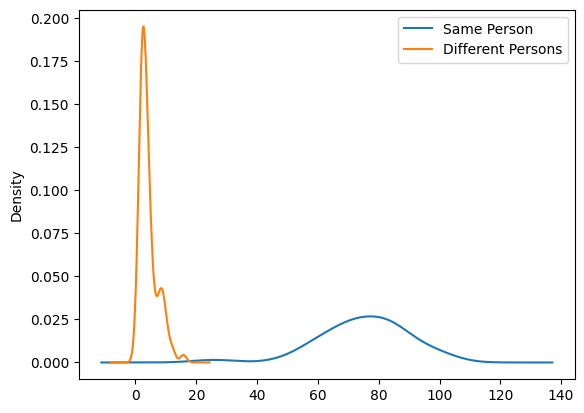

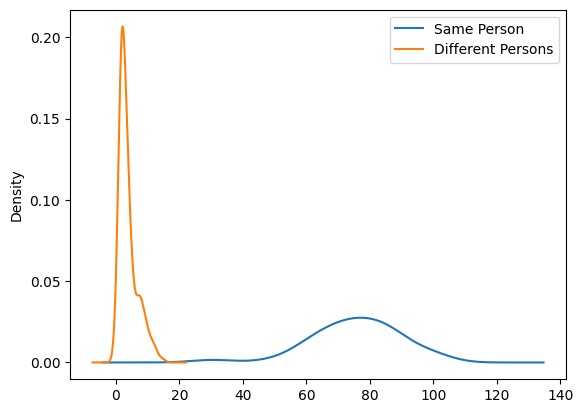

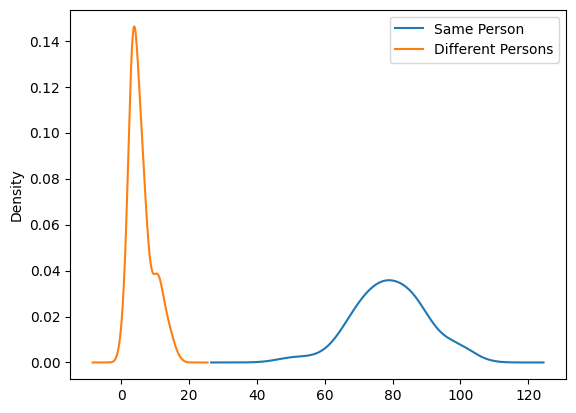

In [33]:
for distance_metric in distance_metrics:
    df[df.actual == "Same Person"][f"{distance_metric}_confidence"].plot.kde(label="Same Person")
    df[df.actual == "Different Persons"][f"{distance_metric}_confidence"].plot.kde(label="Different Persons")
    plt.legend()
    plt.show()
    